# 1. Importing Libraries

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import NearestNeighbors

# from keras.applications.xception import Xception,preprocess_input
# import tensorflow as tf
# from keras.preprocessing import image
# from keras.layers import Input
# from keras.backend import reshape
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

/opt/conda/envs/cs282/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Loading and Preprocessing of Data

In [5]:
images_dir = '/cs282/shared/h-and-m-personalized-fashion-recommendations/images'

In [14]:
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

def getImagePaths(path):
    """
    Function to Combine Directory Path with individual Image Paths
    
    parameters: path(string) - Path of directory
    returns: image_names(string) - Full Image Path
    """
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

def preprocess_img(img_path):
    dsize = (288,288)
    new_image=cv2.imread(img_path)
    new_image=cv2.resize(new_image,dsize,interpolation=cv2.INTER_NEAREST)  
    new_image=data_transforms(new_image)
    new_image=new_image[None,:]
    # new_image=np.expand_dims(new_image,axis=0)
    # new_image=torch.from_numpy(new_image).float() # change preprocessing...
    # new_image=new_image.permute((0, 3, 1, 2))
    return new_image

def load_data():
    img_paths=[]
    # img_paths=getImagePaths(images_dir)[:10000]
    img_paths=getImagePaths(images_dir)
    return img_paths

# 3. Defining model and extracting feature for all the training data

In [25]:
class ResNetPool(nn.Module):
    def __init__(self):
        super(ResNetPool, self).__init__()
        original_model = models.efficientnet_b2(pretrained=True)
        # print(original_model)
        self.features = nn.Sequential(
            *list(original_model.children())[:-1]
        )
    def forward(self, x):
        x = self.features(x)
        return x

def model():
    model = models.efficientnet_b2(pretrained=True)
    # model = models.resnet18(pretrained=True)
    # model = ResNetPool()
    model.eval()
    return model

def feature_extraction(image_data,model):
    features=model(image_data)
    features=features.detach().numpy()
    # features=features.flatten()
    # print(features.shape)
    return features

# 4. Finding the similar image through LSH and cosine similarity

In [26]:
def result_vector_cosine(model,feature_vector,new_img):
    new_feature = model(new_img)
    new_feature = new_feature.detach().numpy()
    new_feature = new_feature.flatten()
    N_result = 12
    nbrs = NearestNeighbors(n_neighbors=N_result, metric="cosine").fit(feature_vector)
    distances, indices = nbrs.kneighbors([new_feature])
    
    return indices

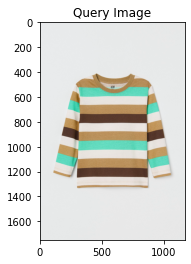

In [27]:
def input_show(data):
    plt.title("Query Image")
    plt.imshow(data)
output=load_data()
input_show(cv2.imread(output[1000]))

# 5. Result
## Vector Cosine

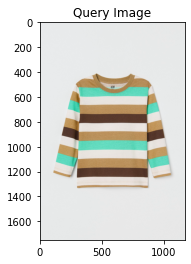

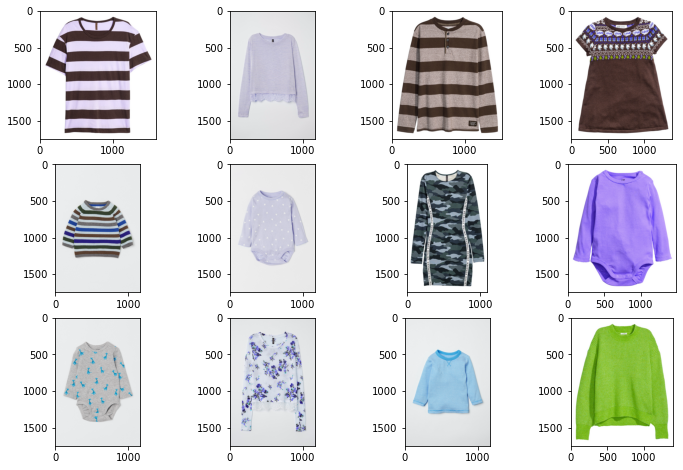

In [28]:
def input_show(data):
    plt.title("Query Image")
    plt.imshow(data)
  
def show_result(data,result):
    fig = plt.figure(figsize=(12,8))
    for i in range(0,12):
        index_result=result[0][i]
        plt.subplot(3,4,i+1)
        plt.imshow(cv2.imread(data[index_result]))
    plt.show()

def main():  
    features=[]
    output=load_data()
    main_model=model()
    #Limiting the data for training
    for i in output[:999]:
        new_img=preprocess_img(i)
        features.append(feature_extraction(new_img,main_model))
    feature_vec = np.array(features)
    feature_vec = np.squeeze(feature_vec, 1)
    result=result_vector_cosine(main_model,feature_vec,preprocess_img(output[1000]))
    input_show(cv2.imread(output[1000]))
    show_result(output,result)
  

if __name__=='__main__':
    main()